## Описание эксперимента
Перед вами таблица, где числовая переменная – непрерывная. Задача – сравнить группы двумя способами: бутстрапом и u-тестом

Описание колонок
value – значения метрики
experimentVariant – Вариант теста (Control – контроль, Treatment – тест)
Задача
1. Сравните результат между тестом и контролем по двум кейсам:

  + Примените бутстрап (с np.mean) и критерий mann-whitney, а потом сравните p-value
  + Примените бутстрап (с np.median) и критерий mann-whitney, а потом сравните p-value.
  
2. Напишите выводы, которые можно сделать на основе анализа примененных критериев


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, mannwhitneyu

from tqdm.auto import tqdm

import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare

#import warnings
#warnings.filterwarnings("ignore")

plt.style.use('ggplot')

### Создадим функцию, которая поможет проверять гипотезы с помощью bootstrap

In [50]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [47]:
df = pd.read_csv('data2/hw_bootstrap.csv', sep=';')
df.head()

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control


In [52]:
df = df.rename(columns={'experimentVariant':'AorB'})
ctrl = df[df.AorB=='Control'].value.apply(lambda x: float(x.replace(',','.')))
test = df[df.AorB=='Treatment'].value.apply(lambda x: float(x.replace(',','.')))

<Axes: xlabel='value', ylabel='Density'>

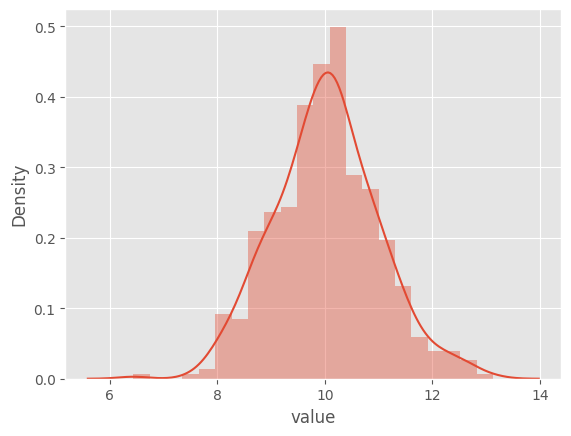

In [105]:
sns.distplot(ctrl) #похоже на норм

Распределение признака в контрольной группе `нормальное`.

In [19]:
df_test = df.query('experimentVariant == "Treatment"').reset_index(drop=True)['value']
df_test.head()

0    10.380495
1     9.546867
2    11.088215
3    10.147274
4     9.789808
Name: value, dtype: float64

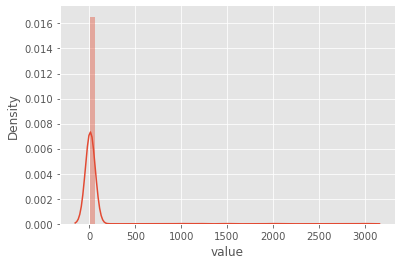

In [21]:
sns.distplot(df_test)
sns.despine()

<Axes: >

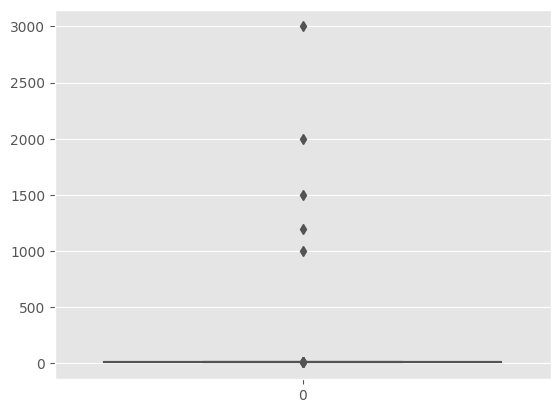

In [101]:
sns.boxplot(test.values)

Распределение признака в тестовой группе `не является нормальным`, заметны выбросы.

### Сравниваем тестовую и контрольную группы с помощью U-критерия Манна-Уитни
* H0: Группы не различаются
* H1: Группы различаются

In [77]:
mannwhitneyu(ctrl, test)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

**Вывод по U-критерию Манна-Уитни:**

Значение `p-value > 0.05` говорит об отсутствии статистически значимых различий между контрольной и тестовой группами (значение U-критерия больше, чем пороговое). Мы не имеем оснований отвергнуть нулевую гипотезу, то есть группы не отличаются.

### Сравниваем средние значения в тестовой и контрольной группах с помощью бутстрапа
* H0: Средние значения в двух группах не различаются
* H1: Средние значения различаются

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3663.05it/s]


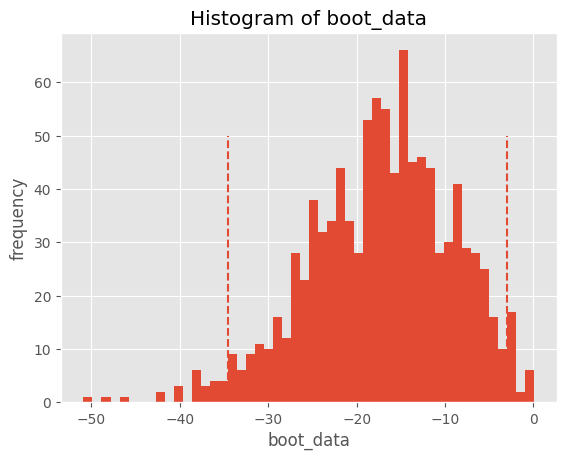

0.033839112146791375

In [59]:
res = get_bootstrap(ctrl, test, boot_it = 1000)
res["p_value"]

In [64]:
res["ci"]

,0
0.025,-34.567987
0.975,-3.006477


In [72]:
test2 = np.array(test)
ctrl2 = np.array(ctrl)

print(bs_compare.difference(test2.mean(), ctrl2.mean()))

print(bs.bootstrap_ab(
    test2, 
    ctrl2, 
    stat_func=bs_stats.mean,
    compare_func=bs_compare.difference
))
#bootstrapped не информативен

17.294632522857277
17.294632522857277    (-1.0115868034997675, 31.610939905242297)


### Вывод по бутстрапу (np.mean):
Средние значения в тестовой и контрольной группах `различаются` на заданном уровне значимости, поскольку в 95-процентный доверительный интервал `не попадает нулевое значение` разницы между двумя средними.

`p-value < 0.05` говорит о том, что при условии верности нулевой гипотезы о равенстве средних в двух группах вероятность получить такое или еще большее отклонение разницы* от 0 составляет менее 5%. То есть полученная нами разница оказалась бы достаточно редким явлением, если бы средние двух групп на самом деле были равны. Значит, мы имеем основание отвергнуть нулевую гипотезу в пользу альтернативной.

*Полученная нами разница - это средняя разница между средними значениями бутстрап-выборок.

### Сравниваем медианы в тестовой и контрольной группах с помощью бутстрапа
* H0: Медианы в двух группах не различаются
* H1: Медианы различаются

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2890.17it/s]


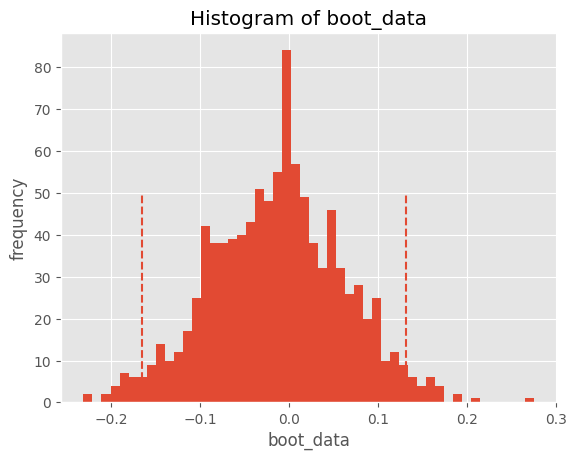

In [109]:
res2 = booted_data_medians = get_bootstrap(
                          ctrl, 
                          test, 
                          boot_it = 1000, 
                          statistic = np.median)

In [110]:
res2['p_value']

0.8615702889425637

In [111]:
res2['ci']

,0
0.025,-0.166207
0.975,0.131174


### Вывод по бутстрапу (np.median):
Медианы в тестовой и контрольной группах `не различаются` на заданном уровне значимости, поскольку в 95-процентный доверительный интервал `попадает нулевое значение` разницы между медианами двух групп.

`p-value > 0.05` говорит о том, что при условии верности нулевой гипотезы о равенстве медиан в двух группах вероятность получить такое или еще большее отклонение разницы* от 0 составляет более 5%. То есть полученная нами разница не оказалась бы редким явлением, если бы медианы двух групп на самом деле были равны. Значит, мы не имеем весомых оснований отвергнуть нулевую гипотезу и остаемся в ее рамках.

*Полученная нами разница - это средняя разница между медианами бутстрап-выборок.

## Сравнение результатов и общие выводы
Можно заметить, что контрольная и тестовая группы имеют разные значения только у последних 5 наблюдений:

In [43]:
df_diff = ctrl.values-test.values
df_diff

array([    0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        ,     0.        ,     0.        ,
      

In [44]:
len(df_diff[df_diff != 0])

5

Причем последние 5 наблюдений в тестовой группе - это `экстремально высокие` значения, которые смещают среднее тестовой группы в большую сторону:

In [45]:
ctrl.mean()

10.026866533804297

In [46]:
test.mean()

27.321499056661573

Это объясняет, почему бутстрап для средних значений показал статистически значимое различие `(p < 0.05)` между средними двух групп.

В то же время медианы двух групп практически идентичны, так как медиана гораздо менее чувствительна к выбросам, чем среднее:

In [47]:
ctrl.median()

10.0184651909296

In [48]:
test.median()

10.02584684253515

Соответственно, бутстрап для медиан показал `отсутствие статистически значимого различия (p > 0.05)` между медианами двух групп.

Непараметрический U-критерий Манна-Уитни также менее чувствителен к выбросам, поскольку использует ранговую шкалу для оценки различий между двумя группами. Данный критерий также показал, что между группами `нет статистически значимых различий`.

В рассмотренном случае стоит доверять бутстрапу для `медиан` и `U-критерию Манна-Уитни`, поскольку они менее чувствительны к экстремально большим (или малым) значениям.